#### Resources:
- Paul Centore - A Zonohedral Approach to Optimal Colours
(https://legacy.sites.fas.harvard.edu/~cs278/papers/zone.pdf)
- Jessica Lee - Theory of Human Tetrachromatic Color Experience and Printing (https://imjal.github.io/theory-of-tetrachromacy/static/pdfs/Lee_TheoryofTet_v1.pdf)

#### Instructions:
Make sure to install Jessica's repository as a Python package using the line below. It requires Python 3.11.

In [6]:
!pip install -q git+https://github.com/VarunNSrivastava/ChromaLab

In [1]:
from chromalab.observer import Observer
from chromalab.spectra import Spectra, Illuminant
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm
import matplotlib.animation as animation
%matplotlib widget

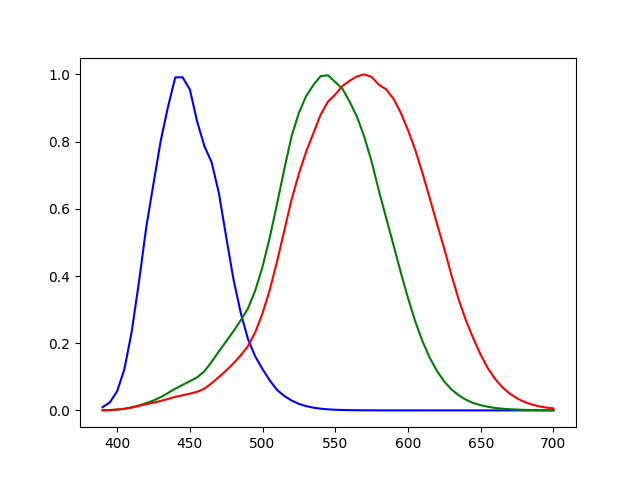

In [2]:
# Cone responses of a typical trichromat.
wavelengths = np.arange(390, 701, 5)
n = len(wavelengths)
standard_trichromat = Observer.trichromat(wavelengths)
illuminant = Illuminant.get("D65").interpolate_values(wavelengths)

standard_trichromat.sensors[0].plot(color="blue")
standard_trichromat.sensors[1].plot(color="green")
standard_trichromat.sensors[2].plot(color="red")
# illuminant.plot(color="gray")

# ax.axvline(x=573, color='gray', linestyle='--', label='Vertical Line')
# ax.axvspan(573, 700, color='lightgray', alpha=0.5)

# ax.set_xlabel('Wavelength')
# ax.set_ylabel('Sensitivity')
# ax.set_title('Cone Response Function')

# plt.savefig('cone_response_high.png', dpi=300, bbox_inches='tight')

plt.show()

In [3]:
# Each point has an indicator reflectance function where R = 1 at a single wavelength and 0 elsewhere.
# These points can be thought of as vectors which form a (linearly dependent) basis.
# The Minkowski sum of these vectors span the object color solid.
# Each point in the solid can be represented as some (non-unique) linear combination of these vectors.
# This represents equations (9), (10), (11), (12), (13).
lms_responses = np.vstack((standard_trichromat.sensors[0].data, 
                           standard_trichromat.sensors[1].data, 
                           standard_trichromat.sensors[2].data)) * illuminant.data

points = np.copy(lms_responses).T

# As shown in Centore's paper, these vertices form the shape of the solid.
# This represents the matrix in (7).
vertices = np.zeros((n + 1, n, 3))
for i in range(1, n + 1):
    for j in range(n):
        vertices[i, j] = vertices[i - 1, j] + points[(i + j - 1) % n]

# This represents the diagram in (8)
faces = np.zeros((n * (n - 1), 4, 3))
face_colors = np.zeros((n * (n - 1), 3))
for i in tqdm(range(1, n)):
    for j in range(n):
        faces[((i - 1) * n) + j, 0] = vertices[i, j]
        faces[((i - 1) * n) + j, 1] = vertices[i - 1, (j + 1) % n]
        faces[((i - 1) * n) + j, 2] = vertices[i, (j + 1) % n]
        faces[((i - 1) * n) + j, 3] = vertices[i + 1, j]
        
        # Calculate the reflectance on each face by using the reflectance of one of its vertices.
        # Since each vertex can be thought of as a linear combination of the basis vectors, 
        # the vertex's reflectance is the sum of reflectances of those vectors that made up the vertex.
        reflectance_data = np.zeros(n)
        for k in range(i):
            reflectance_data[(j + k) % n] = 1
        reflectance = Spectra(wavelengths=wavelengths, data=reflectance_data)
        face_colors[(i - 1) * n + j] = reflectance.to_rgb(illuminant)    # Bottleneck. Takes about 3ms. 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:22<00:00,  2.80it/s]


In [4]:
# Uses ideas from Jessica's paper, on chapter 3.2 The Max Basis.
# We use the cutpoints that Jessica shows to be optimal for the trichromatic case.
cutpoint_1 = 487
cutpoint_2 = 573
index_1 = None
index_2 = None
for i, wavelength in enumerate(wavelengths):
    if index_1 is None and wavelength > cutpoint_1:
        index_1 = i
    if index_2 is None and wavelength >= cutpoint_2:
        index_2 = i
        break

# We calculate the vectors p1, p2 and p3 as shown in the paper.
# We "project the partition into the cone response basis" by summing up all the lms_responses within each partition.
# Note that our earlier calculations for lms_responses includes the illuminant already.
p1 = np.sum(lms_responses[:, :index_1], axis=1).reshape((3, 1))
p2 = np.sum(lms_responses[:, index_1:index_2], axis=1).reshape((3, 1))
p3 = np.sum(lms_responses[:, index_2:], axis=1).reshape((3, 1))

# We then create a transformation matrix that maps p1 to (1, 0, 0), p2 to (0, 1, 0) and p3 to (1, 0, 0).
# p1, p2 and p3 correspond to the ideal R, G, B points on our object color solid, 
# and we are mapping them onto the R, G, B points on the RGB cube.
# We are essentially "stretching" our object color solid so that it approximates the RGB cube.
transformation_matrix = np.linalg.inv(np.hstack((p1, p2, p3)))
faces_transformed = np.matmul(faces, transformation_matrix.T)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:18<00:00,  3.84it/s]


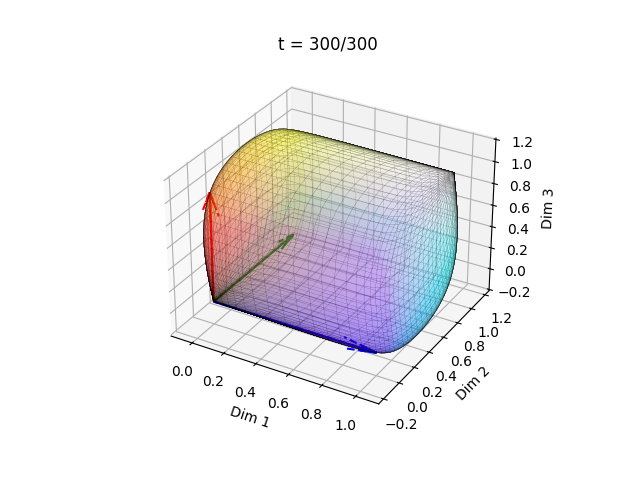

In [5]:
video_filename = 'object_morphing.mp4'
writer = animation.FFMpegWriter(fps=60)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

with writer.saving(fig, video_filename, dpi=400):
    count = 1
    total = 300
    for t in tqdm(np.linspace(0.8, 1.0, total)):
        p1_end = (p1 * (1 - t)) + (t * np.array([1, 0, 0])).reshape((3, 1))
        p2_end = (p2 * (1 - t)) + (t * np.array([0, 1, 0])).reshape((3, 1))
        p3_end = (p3 * (1 - t)) + (t * np.array([0, 0, 1])).reshape((3, 1))
        end_matrix = np.hstack((p1_end, p2_end, p3_end))
        inverse_matrix = np.linalg.inv(np.hstack((p1, p2, p3)))
        transformation_matrix = end_matrix @ inverse_matrix
        faces_transformed = np.matmul(faces, transformation_matrix.T)
        
        ax.cla()  # Clear the previous plot
        poly3d = Poly3DCollection(faces_transformed, linewidths=0.05, edgecolors='k', alpha=0.3)
        poly3d.set_facecolor(face_colors)
        ax.add_collection3d(poly3d)

        # Plot vectors
        origin = np.zeros((3, 3))
        vectors = np.hstack((p1_end, p2_end, p3_end))
        target = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
        colors = ['b', 'g' ,'r']
        for i in range(3):
            ax.quiver(origin[0, i], origin[0, i], origin[0, i], 
                      vectors[0, i], vectors[1, i], vectors[2, i],
                      color=colors[i], arrow_length_ratio=0.1)

            ax.quiver(origin[0, i], origin[0, i], origin[0, i], 
                      target[0, i], target[1, i], target[2, i],
                      color=colors[i], linestyle='dashed', arrow_length_ratio=0.2)
        
        ax.set_xlabel('Dim 1')
        ax.set_ylabel('Dim 2')
        ax.set_zlabel('Dim 3')
        ax.set_title(f"t = {count}/{total}")

        writer.grab_frame()
        count += 1

    for i in range(100):
        writer.grab_frame()

# Optionally, show the final plot
plt.show()

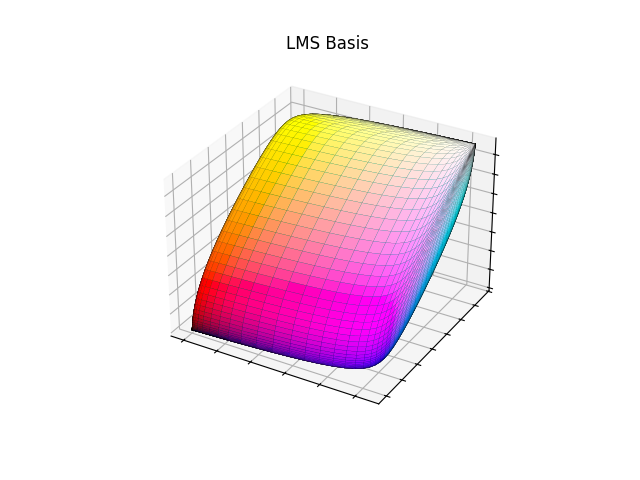

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
poly3d = Poly3DCollection(faces, linewidths=0.05, edgecolors='k')
poly3d.set_facecolor(face_colors)
ax.add_collection3d(poly3d)
ax.set_title('LMS Basis')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.savefig('solid_lms_basis.png', dpi=300, bbox_inches='tight')
plt.show()